In [1]:
import numpy as np
from scipy import misc, fft as scipy_fft
from matplotlib import pyplot, colors, cm
from PIL import Image
from IPython.display import display

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
})

def sampling_coordinates(n, s):
    return (np.arange(n) - (n-1)/2) * s/n

def evaluate(x, xi, amplitudes, phases):
    return np.sum(amplitudes * np.cos(2.0 * np.pi * xi * x[:, np.newaxis] + phases), axis=-1)

def spatial_display_to_eye(x_a, x_b, z_a, z_b, z_r, z_f):
    x_r = (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b
    x_p = z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b
    return x_r, x_p

def spatial_eye_to_display(x_r, x_p, z_a, z_b, z_r, z_f):
    x_a = (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p
    x_b = (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p
    return x_a, x_b

def frequency_display_to_eye(xi_a, xi_b, z_a, z_b, z_r, z_f):
    xi_r = (z_a/z_r) * xi_a + (z_b/z_r) * xi_b
    xi_p = (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b
    return xi_r, xi_p

def frequency_eye_to_display(xi_r, xi_p, z_a, z_b, z_r, z_f):
    xi_a = (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p
    xi_b = (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p
    return xi_a, xi_b

def compute_imaging_tensor(x_r, x_a, x_b, s_p, w_a, w_b, z_r, z_a, z_b, z_f):
    """Return the flatland imaging tensor with shape (res_r, res_a, res_b)."""
    # Ratios for projection of plane A and plane B to the pupil plane
    ratio_a = np.reciprocal(1.0 - z_a/z_f)
    ratio_b = np.reciprocal(1.0 - z_b/z_f)
    # Project display samples to the pupil plane
    x_a_at_p = (x_a[np.newaxis, ..., np.newaxis] - x_r[..., np.newaxis, np.newaxis] * (z_a/z_r)) * ratio_a
    x_b_at_p = (x_b[np.newaxis, np.newaxis, ...] - x_r[..., np.newaxis, np.newaxis] * (z_b/z_r)) * ratio_b
    # Compute the lower and upper bounds for each intersection of plane A intervals, plane B intervals and the pupil aperture
    lower_bound = np.maximum(np.maximum(-s_p/2, x_a_at_p - np.abs(ratio_a * w_a/2)), x_b_at_p - np.abs(ratio_b * w_b/2))
    upper_bound = np.minimum(np.minimum( s_p/2, x_a_at_p + np.abs(ratio_a * w_a/2)), x_b_at_p + np.abs(ratio_b * w_b/2))
    # Return the lengths of the intersection intervals normalized by the pupil diameter
    return np.maximum(np.subtract(upper_bound, lower_bound) / s_p, 0.0)

def display_image(values, normalize=True, color_map=None):
    """Display an array of values as an image using a color map."""
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))

In [2]:
def plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f, spatial_size, frequency_size):
    n_p = 99

    x_r = sampling_coordinates(n_r, s_r)

    x_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * s_b), 99 * n_a))
    xi_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * n_a/s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * n_b/s_b), 99 * n_a))

    window_x_r = (np.array([-s_r/2, -s_r/2, s_r/2, s_r/2]), np.array([100, -100, -100, 100]))
    window_x_p = (np.array([100, -100, -100, 100]), np.array([-s_p/2, -s_p/2, s_p/2, s_p/2]))
    xi_p = sampling_coordinates(n_p, n_p/s_p)
    xi_r = sampling_coordinates(n_r, n_r/s_r)

    fig, axs = pyplot.subplots(2, 2, constrained_layout=True, figsize=(24, 24))

    axs[0, 0].set_title('Eye spatial domain', fontsize=14)
    axs[0, 0].set_xlabel(r'$x_r$', fontsize=14)
    axs[0, 0].set_ylabel(r'$x_p$', fontsize=14)
    axs[0, 0].set_aspect('equal')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    axs[0, 0].set_xlim(-spatial_size/2, spatial_size/2)
    axs[0, 0].set_ylim(-spatial_size/2, spatial_size/2)

    axs[0, 0].scatter(x_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
    axs[0, 0].scatter(*spatial_display_to_eye(*x_ab, z_a, z_b, z_r, z_f), color='lfd:signal', s=3**2, zorder=3)
    axs[0, 0].plot(*spatial_display_to_eye(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-1000.0, 1000.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 0].plot(*spatial_display_to_eye(np.tile([-1000.0, 1000.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 0].plot([-1000.0, 1000.0], [0.0, 0.0], color='lfd:retina')
    axs[0, 0].fill(*window_x_p, alpha=0.2, color='lfd:pupil')
    axs[0, 0].fill(*window_x_r, alpha=0.2, color='lfd:retina')
    axs[0, 0].fill(*spatial_display_to_eye(np.repeat(x_ab[0], 5) + np.tile(np.array([-1, -1, 1, 1, np.nan]) * w_a/2, 99 * n_a * 99 * n_b),
                                        np.repeat(x_ab[1], 5) + np.tile(np.array([1, -1, -1, 1, np.nan]) * w_b/2, 99 * n_a * 99 * n_b), z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:signal')

    axs[0, 1].set_title('Eye frequency domain', fontsize=14)
    axs[0, 1].set_xlabel(r'$\xi_r$', fontsize=14)
    axs[0, 1].set_ylabel(r'$\xi_p$', fontsize=14)
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    axs[0, 1].set_xlim(-frequency_size/2, frequency_size/2)
    axs[0, 1].set_ylim(-frequency_size/2, frequency_size/2)

    axs[0, 1].scatter(xi_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
    axs[0, 1].scatter(*frequency_display_to_eye(*xi_ab, z_a, z_b, z_r, z_f), color='lfd:signal', s=3**2, zorder=3)
    axs[0, 1].plot(*frequency_display_to_eye(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-1000.0, 1000.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(np.tile([-1000.0, 1000.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye( np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-1000.0, 1000.0, np.nan], 98), z_a, z_b, z_r, z_f), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(-np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-1000.0, 1000.0, np.nan], 98), z_a, z_b, z_r, z_f), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(np.tile([-1000.0, 1000.0, np.nan], 98),  np.repeat(np.arange(1, 99) / w_b, 3), z_a, z_b, z_r, z_f), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(np.tile([-1000.0, 1000.0, np.nan], 98), -np.repeat(np.arange(1, 99) / w_b, 3), z_a, z_b, z_r, z_f), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[0, 1].plot(np.tile([-1000.0, 1000.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), linestyle='dashed', color='lfd:pupil')
    axs[0, 1].plot(np.tile([-1000.0, 1000.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), linestyle='dashed', color='lfd:pupil')
    axs[0, 1].plot([-1000.0, 1000.0], [0.0, 0.0], color='lfd:retina')

    axs[1, 0].set_title('Display spatial domain', fontsize=14)
    axs[1, 0].set_xlabel(r'$x_a$', fontsize=14)
    axs[1, 0].set_ylabel(r'$x_b$', fontsize=14)
    axs[1, 0].set_aspect('equal')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])
    axs[1, 0].set_xlim(-spatial_size/2, spatial_size/2)
    axs[1, 0].set_ylim(-spatial_size/2, spatial_size/2)

    axs[1, 0].scatter(*spatial_eye_to_display(x_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
    axs[1, 0].scatter(*x_ab, color='lfd:signal', s=3**2, zorder=3)
    axs[1, 0].plot(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-1000.0, 1000.0, np.nan], 99), color='lfd:signal')
    axs[1, 0].plot(np.tile([-1000.0, 1000.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), color='lfd:signal')
    axs[1, 0].plot(*spatial_eye_to_display(np.array([-1000.0, 1000.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
    axs[1, 0].fill(*spatial_eye_to_display(*window_x_p, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:pupil')
    axs[1, 0].fill(*spatial_eye_to_display(*window_x_r, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:retina')
    axs[1, 0].fill(np.repeat(x_ab[0], 5) + np.tile(np.array([-1, -1, 1, 1, np.nan]) * w_a/2, 99 * n_a * 99 * n_b),
                np.repeat(x_ab[1], 5) + np.tile(np.array([1, -1, -1, 1, np.nan]) * w_b/2, 99 * n_a * 99 * n_b), alpha=0.2, color='lfd:signal')

    axs[1, 1].set_title('Display frequency domain', fontsize=14)
    axs[1, 1].set_xlabel(r'$\xi_a$', fontsize=14)
    axs[1, 1].set_ylabel(r'$\xi_b$', fontsize=14)
    axs[1, 1].set_aspect('equal')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    axs[1, 1].set_xlim(-frequency_size/2, frequency_size/2)
    axs[1, 1].set_ylim(-frequency_size/2, frequency_size/2)

    axs[1, 1].scatter(*frequency_eye_to_display(xi_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
    axs[1, 1].scatter(*xi_ab, color='lfd:signal', s=3**2, zorder=3)
    axs[1, 1].plot(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-1000.0, 1000.0, np.nan], 99), color='lfd:signal')
    axs[1, 1].plot(np.tile([-1000.0, 1000.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), color='lfd:signal')
    axs[1, 1].plot( np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-1000.0, 1000.0, np.nan], 98), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[1, 1].plot(-np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-1000.0, 1000.0, np.nan], 98), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[1, 1].plot(np.tile([-1000.0, 1000.0, np.nan], 98),  np.repeat(np.arange(1, 99) / w_b, 3), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[1, 1].plot(np.tile([-1000.0, 1000.0, np.nan], 98), -np.repeat(np.arange(1, 99) / w_b, 3), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[1, 1].plot(*frequency_eye_to_display(np.tile([-1000.0, 1000.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
    axs[1, 1].plot(*frequency_eye_to_display(np.tile([-1000.0, 1000.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
    axs[1, 1].plot(*frequency_eye_to_display(np.array([-1000.0, 1000.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')

In the spatial domain we have:
$$ \large \begin{align*}
    s &= \text{period of the spatial signal} \\
    n &= \text{number of spatial samples in one period of the spatial signal} \\
    \Delta x &= \text{spatial sampling period, i.e., the distance between spatial samples} \\
\end{align*} $$

In the frequency domain we have:
$$ \large \begin{align*}
    \sigma &= \text{period of the signal spectrum} \\
    n &= \text{number of frequency samples in one period of the signal spectrum} \\
    \Delta \xi &= \text{frequency sampling period, i.e., the distance between frequency samples} \\
\end{align*} $$

We can always describe $\Delta x$, $\Delta \xi$ and $\sigma$ in terms of $n$ and $s$:
$$ \large \begin{align*}
    \Delta x &= \frac{s}{n} && (1)\\
    \Delta \xi &= \frac{1}{s} && (2)\\
    \sigma &= \frac{n}{s} && (3)\\
\end{align*} $$

Display frequencies and eye frequencies relate to each other according to:
$$ \large \begin{align*}
    z_{a} \, \xi_{a} + z_{b} \, \xi_{b} &= z_{r} \, \xi_{r} && (4)\\
    (z_{f} - z_{a}) \, \xi_{a} + (z_{f} - z_{b}) \, \xi_{b} &= z_{f} \, \xi_{p} && (5)\\
\end{align*} $$

For a two-dimensional scene it is convenient to choose $z_{f} = \infty$. In addition to simplifying the equations it is also the most comfortable focus distance for the viewer.
$$ \large \begin{align*}
    z_{f} = \infty \implies \xi_{a} + \xi_{b} = \xi_{p} && (6)\\
\end{align*} $$

The $\xi_{r}$ and $\xi_{p}$ axes are described in eye space simply as $\xi_{p} = 0$ and $\xi_{r} = 0$ respectively. Therefore they can be described in display space as:
$$ \large \begin{align*}
    \xi_{p} = 0 &\implies
    \begin{cases}
        \xi_{a} = \frac{-z_{r}}{z_{b} - z_{a}} \xi_{r} \\
        \xi_{b} = \frac{-z_{r}}{z_{a} - z_{b}} \xi_{r} \\
    \end{cases} && (7)\\
    \xi_{r} = 0 &\implies
    \begin{cases}
        \xi_{a} = \frac{z_{b}}{z_{b} - z_{a}} \xi_{p} \\
        \xi_{b} = \frac{z_{a}}{z_{a} - z_{b}} \xi_{p} \\
    \end{cases} && (8)\\
\end{align*} $$

For a pupil with diameter $d_{p}$, the spatial signal is multiplied over the pupil axis by a rectangular function of width $d_{p}$. Therefore, the signal spectrum is convolved over the pupil frequency axis by a $\mathrm{sinc}$ with zeros on every $\xi_{p}$ multiple of $1/d_{p}$.

To avoid interference due to spectral leakage of the pupil from display frequency samples out of the retina frequency axis we will choose:

$$ \large \begin{align*}
    \Delta \xi_{a} = \Delta \xi_{b} = \frac{1}{d_{p}} \implies s_{a} = s_{b} = d_{p} && (9)\\
\end{align*} $$

This way, the display frequency samples also align over the retina frequency axis and induces a period over the retina according to:
$$ \large \begin{align*}
    s_{r} = \left\lvert \frac{z_r}{z_b - z_a} \right\rvert d_{p} && (10)\\
\end{align*} $$

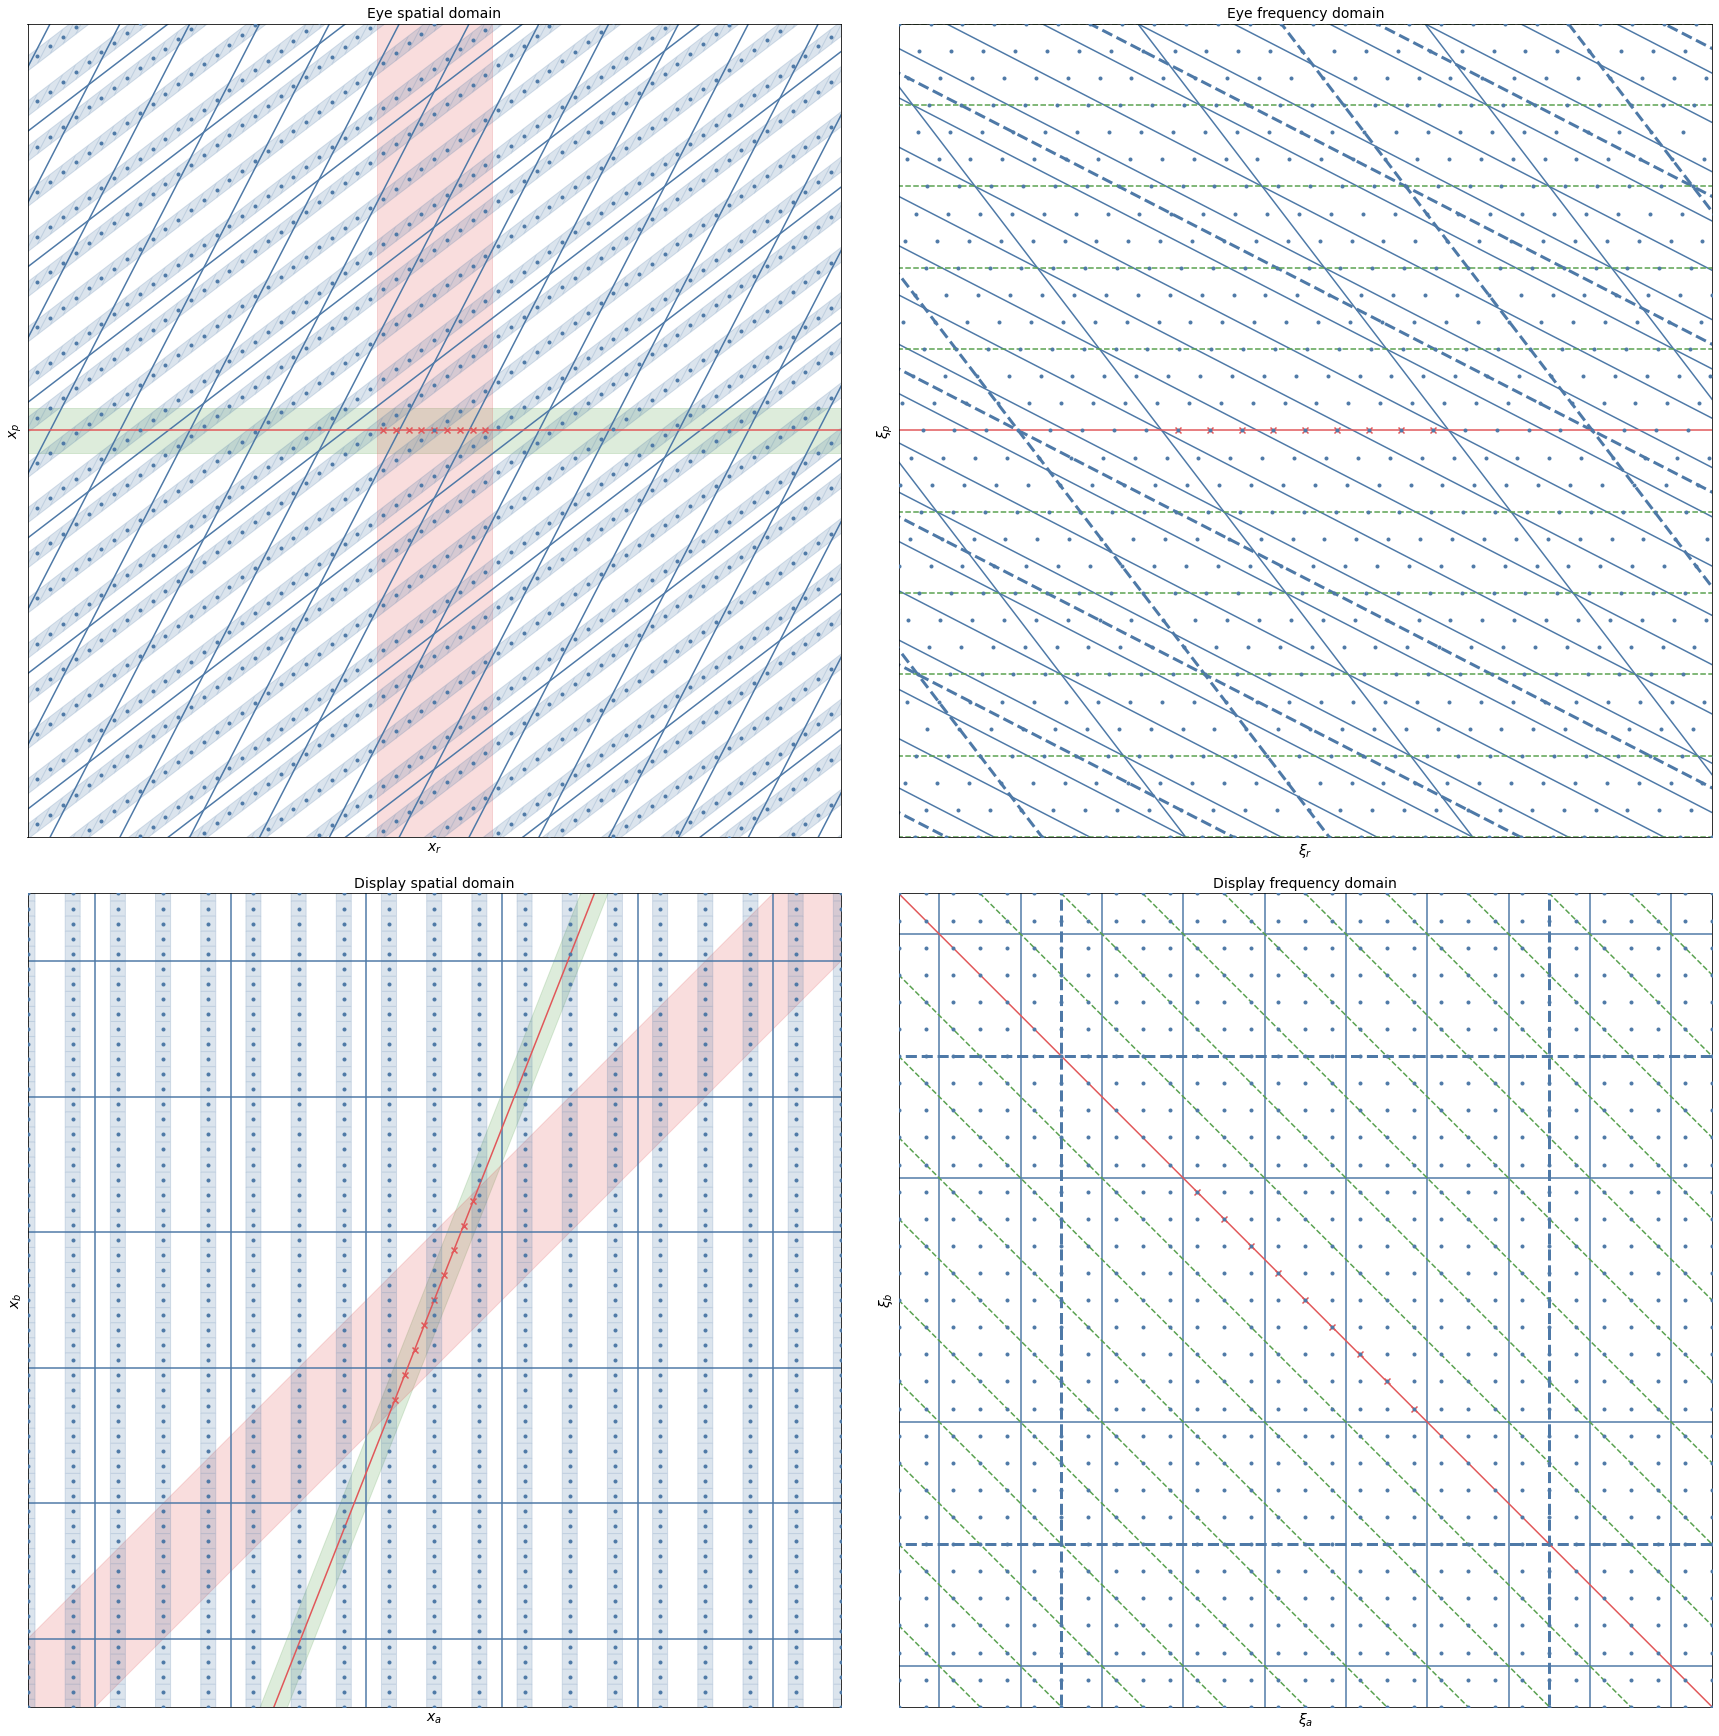

In [3]:
z_a = 13.0
z_b = 33.0
z_r = -17.0
z_f = np.inf

n_a = 3
n_b = 9
n_r = 9

s_p = 5.0

s_a = s_p * 3
s_b = s_p * 3

s_r = np.abs(z_r/(z_b - z_a)) * s_p * 3

#w_a = (s_a / n_a)
w_b = (s_b / n_b)

w_a = w_b

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f, 90, 2)

Retina values (min: 0.0, max: 1.0):


Retina spectrum:


Display spectrum:


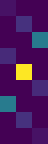

Display values (min: 0.0, max: 1.0):


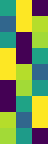

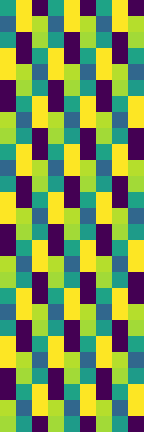

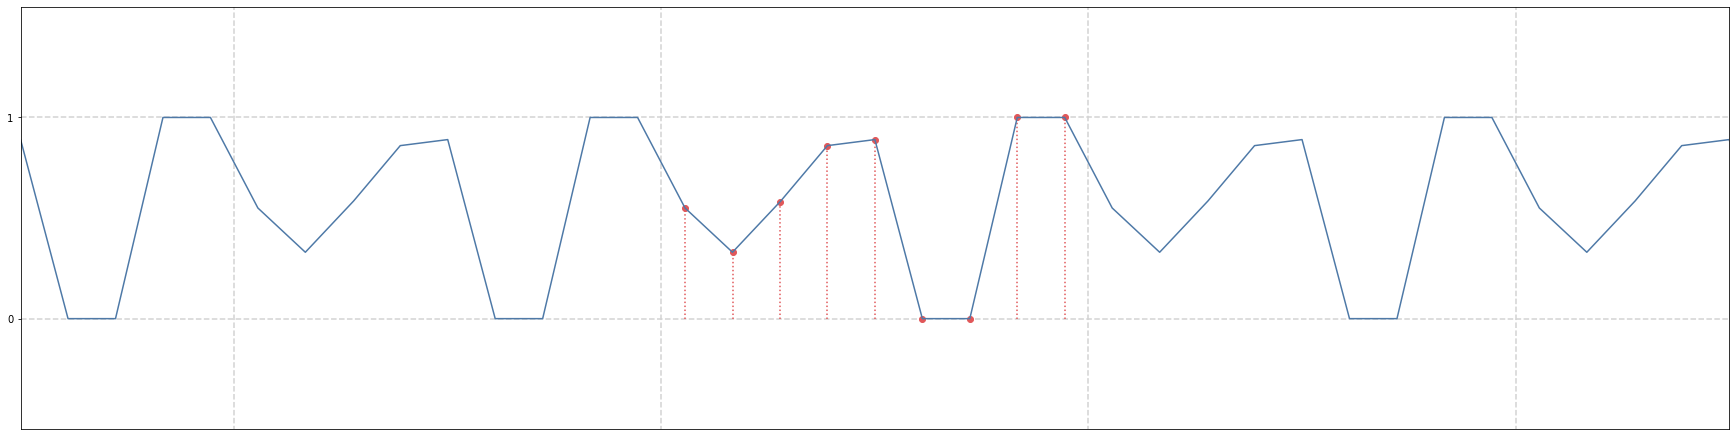

In [4]:
samples_r = np.array([0.55, 0.33, 0.58, 0.86, 0.89, 0.00, 0.00, 1.00, 1.00])

print('Retina values (min: {}, max: {}):'.format(np.amin(samples_r), np.amax(samples_r)))
display_image(np.kron(samples_r, np.ones((16, 16))))

spectrum_r = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples_r)))/n_r

print('Retina spectrum:')
display_image(np.kron(np.abs(spectrum_r), np.ones((16, 16))))

spectrum_ab = np.zeros((n_a, n_b), dtype=spectrum_r.dtype)
spectrum_ab[np.flip(np.mod(np.arange(n_r), n_a)), np.mod(np.arange(n_r), n_b)] = spectrum_r

print('Display spectrum:')
display_image(np.kron(np.abs(spectrum_ab), np.ones((16, 16))))

values_ab = np.real(scipy_fft.fftshift(scipy_fft.ifft2(scipy_fft.ifftshift(spectrum_ab * n_a * n_b))))

print('Display values (min: {}, max: {}):'.format(np.amin(values_ab), np.amax(values_ab)))
display_image(np.kron(values_ab, np.ones((16, 16))))

values_ab = np.tile(values_ab, (3, 3))
display_image(np.kron(values_ab, np.ones((16, 16))))
values_ab = np.tile(values_ab, (11, 11))

x_r = sampling_coordinates(5 * 999, 5 * s_r)
x_a = sampling_coordinates(33 * n_a, 33 * s_a)
x_b = sampling_coordinates(33 * n_b, 33 * s_b)

img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p, w_a, w_b, z_r, z_a, z_b, z_f)
values_r = np.flip(np.sum(values_ab * img_tsr, axis=(1, 2)))

fig, ax = pyplot.subplots(constrained_layout=True, figsize=(24, 6))

x_plot_size = 4 * s_r

ax.set_xticks([])
ax.set_xlim(-x_plot_size/2, x_plot_size/2)
ax.set_yticks([0.0, 1.0])
ax.set_ylim(-0.55, 1.55)
ax.hlines([0.0, 1.0], -x_plot_size/2, x_plot_size/2, linestyle='dashed', color='lightgrey', zorder=-1)
ax.vlines(np.array([-1.5, -0.5, 0.5, 1.5]) * s_r, -4, 5, linestyle='dashed', color='lightgrey', zorder=-1)
[ln.set_color('lfd:retina') for ln in ax.stem(sampling_coordinates(n_r, s_r), samples_r, linefmt=':', basefmt='none')[0:2]]
ax.plot(x_r, values_r  * np.mean(samples_r) / np.mean(values_r[2*999:3*999]), color='lfd:signal')

pass

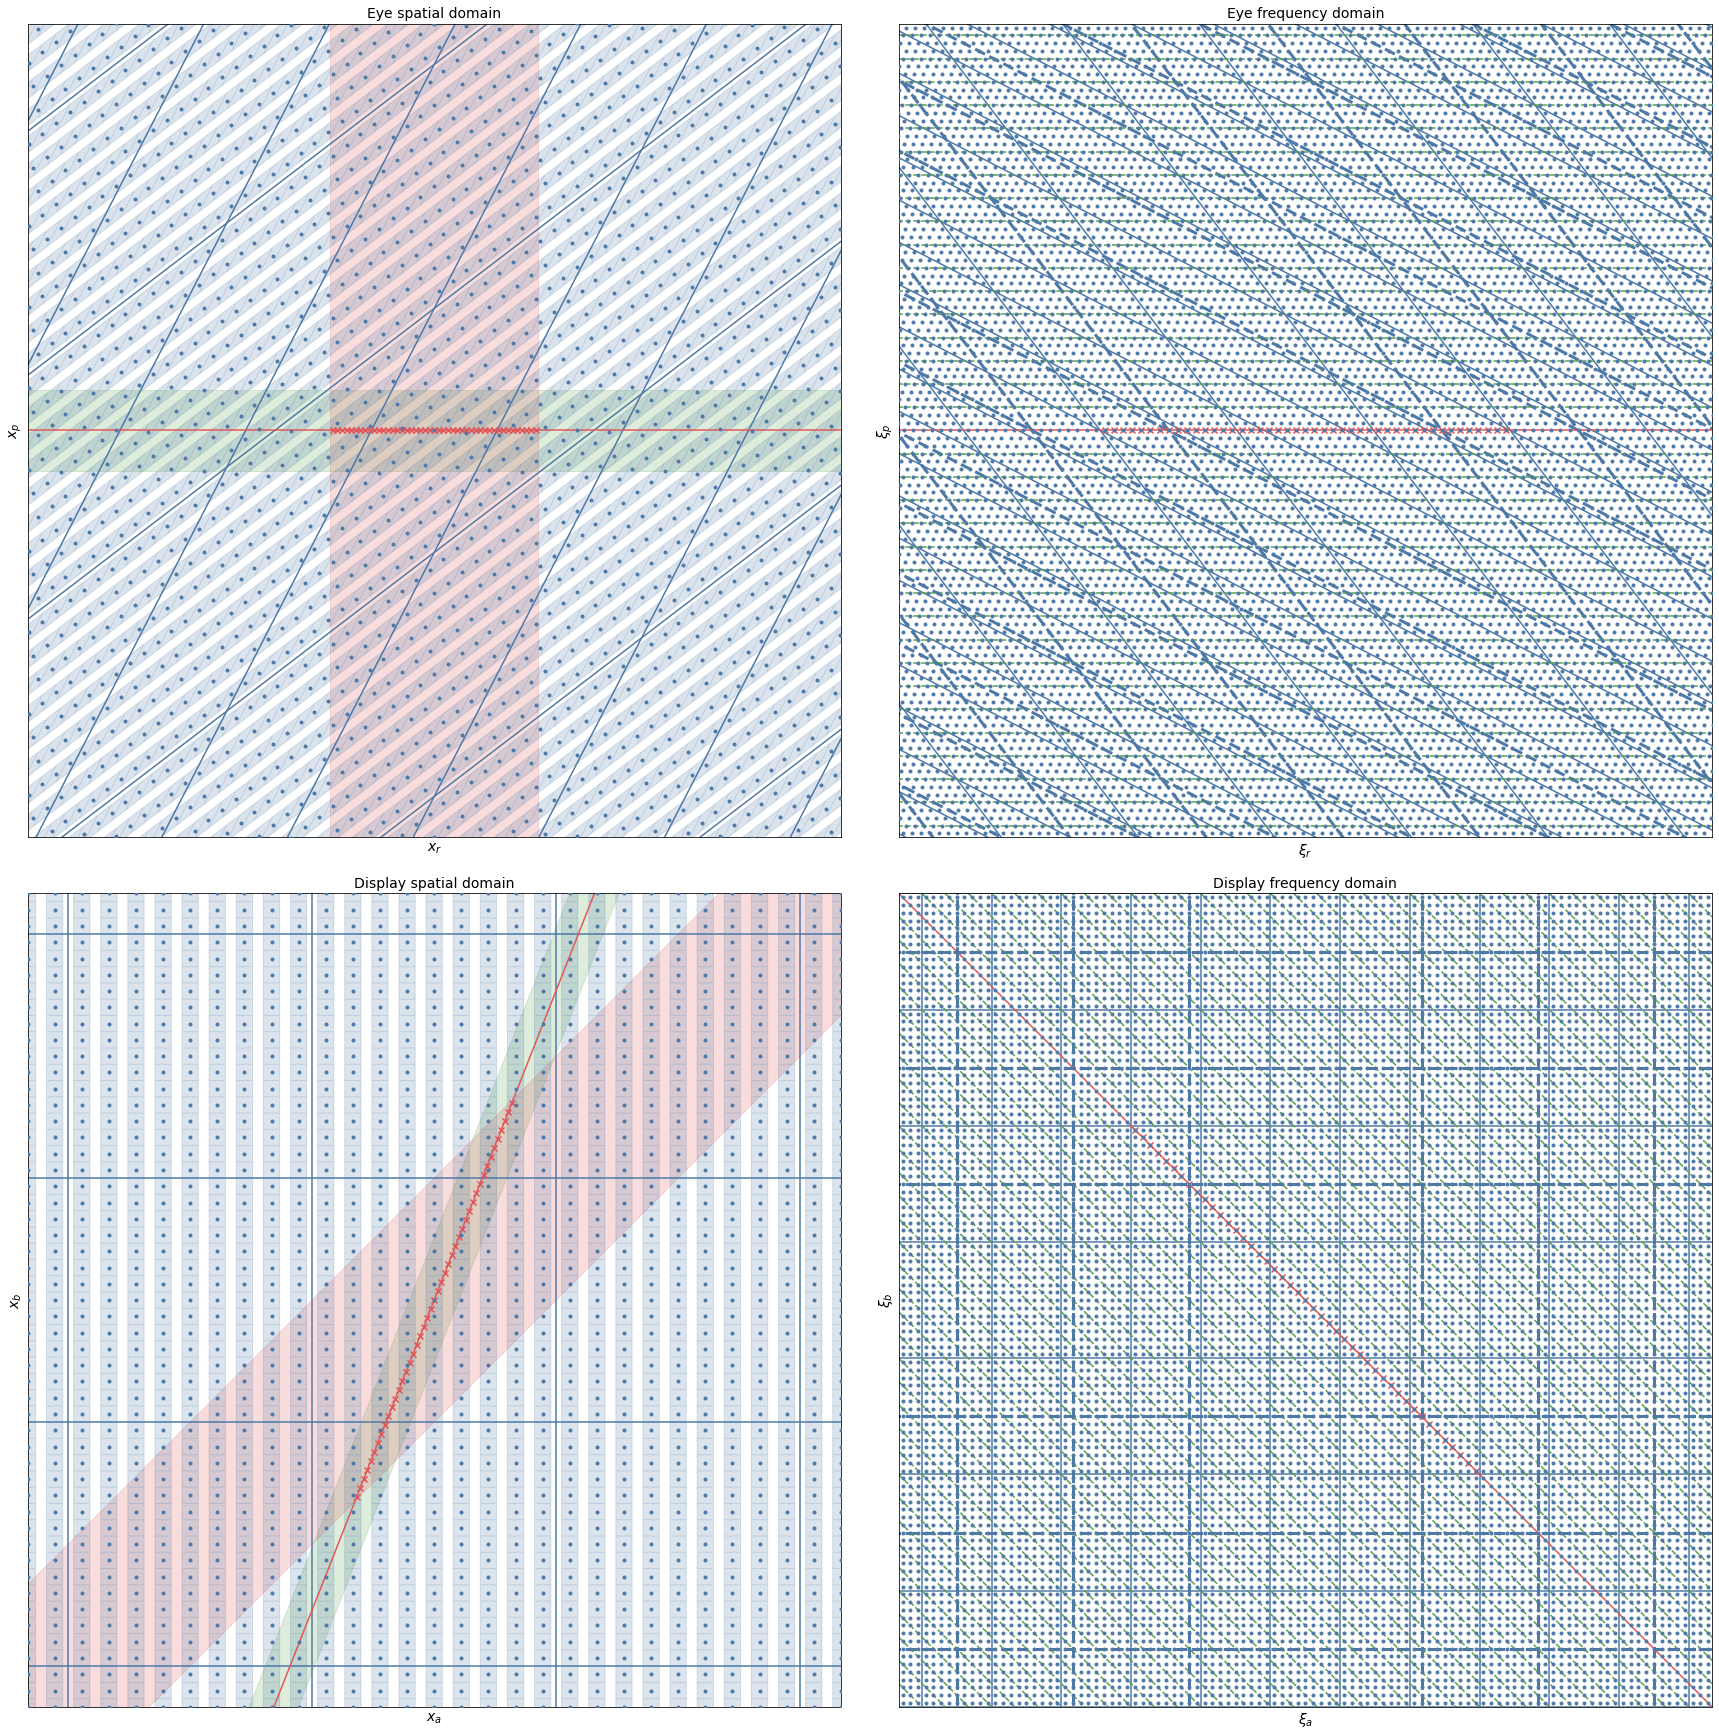

In [5]:
z_a = 13.0
z_b = 33.0
z_r = -17.0
z_f = np.inf

n_a = 9
n_b = 15
n_r = 45

s_p = 5.0

s_a = s_p * 3
s_b = s_p * 3

s_r = np.abs(z_r/(z_b - z_a)) * s_p * 3

#w_a = (s_a / n_a)
w_b = (s_b / n_b)

w_a = w_b

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f, 50, 7)

Retina values (min: 0.019742293519900644, max: 0.999391995705757):


Retina spectrum:


Display spectrum:


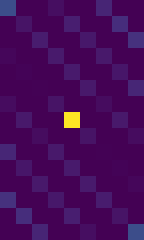

Display values (min: 0.01974229351990059, max: 0.999391995705757):


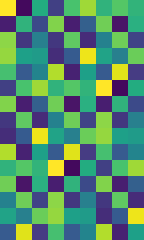

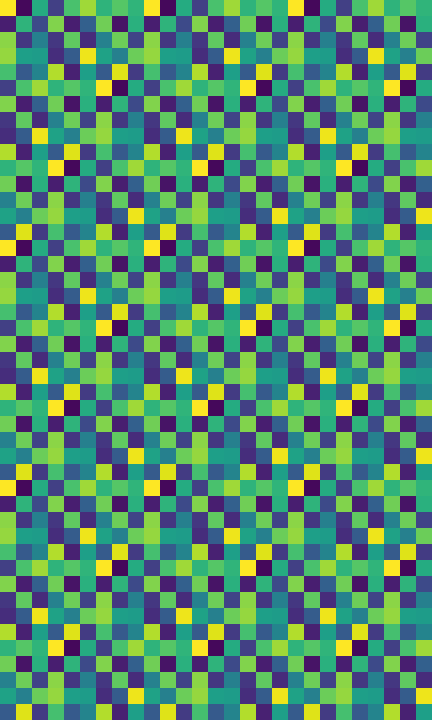

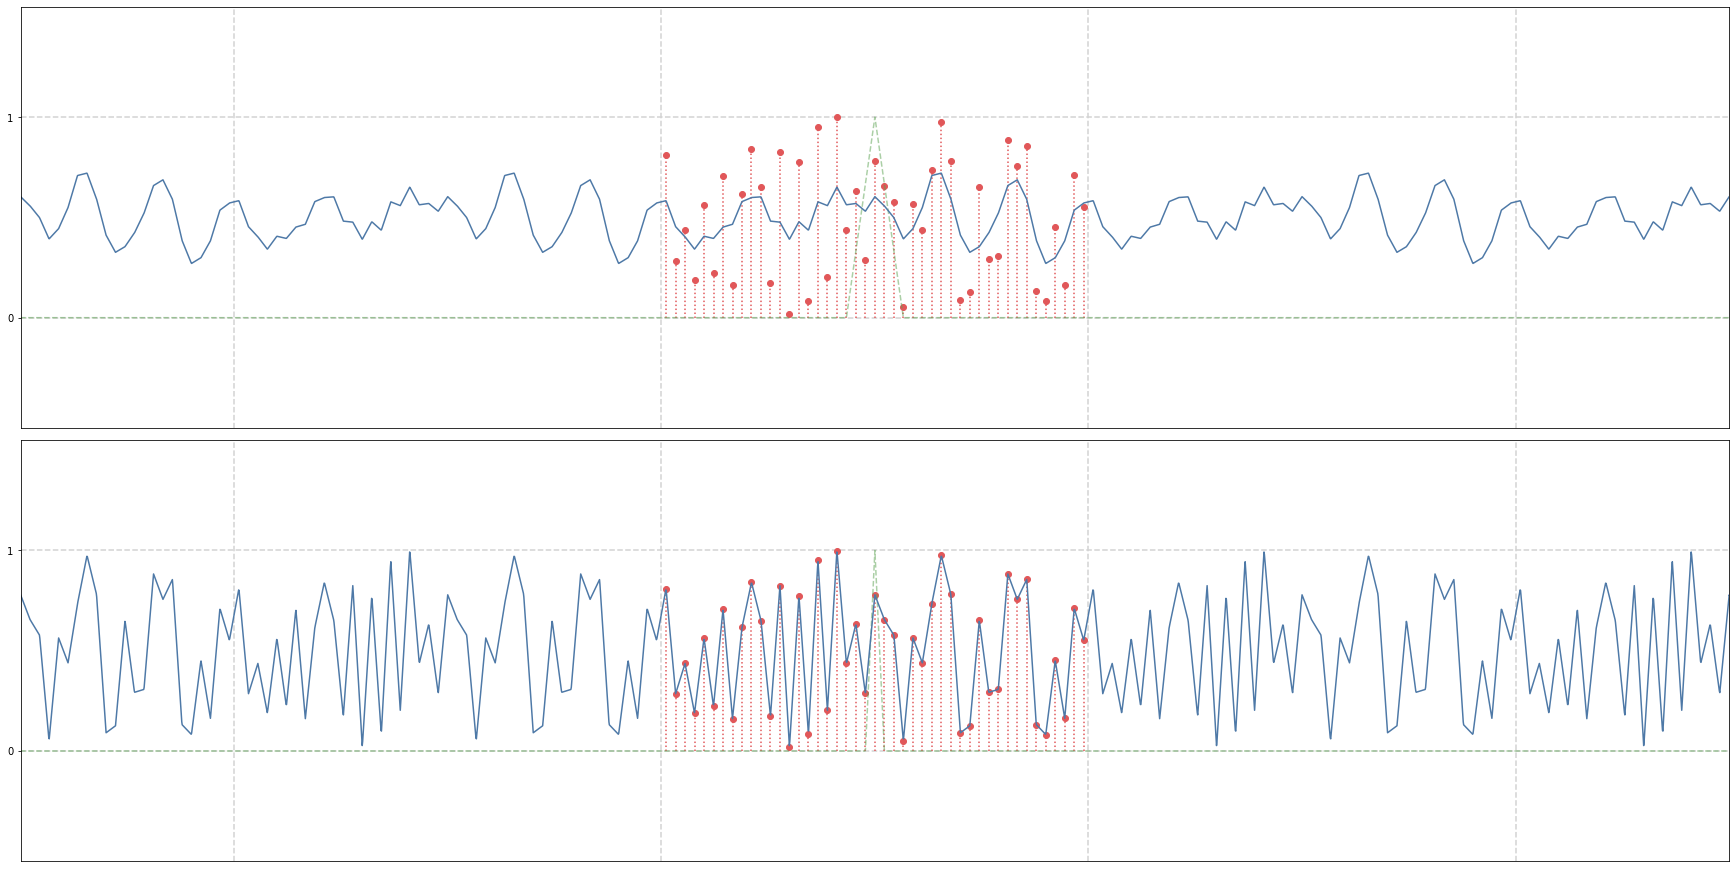

In [6]:
samples_r = np.random.sample(n_r)

print('Retina values (min: {}, max: {}):'.format(np.amin(samples_r), np.amax(samples_r)))
display_image(np.kron(samples_r, np.ones((16, 16))))

spectrum_r = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples_r)))/n_r

print('Retina spectrum:')
display_image(np.kron(np.abs(spectrum_r), np.ones((16, 16))))

spectrum_ab = np.zeros((n_a, n_b), dtype=spectrum_r.dtype)
spectrum_ab[np.flip(np.mod(np.arange(n_r), n_a)), np.mod(np.arange(n_r), n_b)] = spectrum_r

print('Display spectrum:')
display_image(np.kron(np.abs(spectrum_ab), np.ones((16, 16))))

values_ab = np.real(scipy_fft.fftshift(scipy_fft.ifft2(scipy_fft.ifftshift(spectrum_ab * n_a * n_b))))

print('Display values (min: {}, max: {}):'.format(np.amin(values_ab), np.amax(values_ab)))
display_image(np.kron(values_ab, np.ones((16, 16))))

values_ab = np.tile(values_ab, (3, 3))
display_image(np.kron(values_ab, np.ones((16, 16))))
values_ab = np.tile(values_ab, (11, 11))

x_r = sampling_coordinates(5 * 999, 5 * s_r)
x_a = sampling_coordinates(33 * n_a, 33 * s_a)
x_b = sampling_coordinates(33 * n_b, 33 * s_b)

fig, axs = pyplot.subplots(2, constrained_layout=True, figsize=(24, 12))

x_plot_size = 4 * s_r

for ax in axs:
    ax.set_xticks([])
    ax.set_xlim(-x_plot_size/2, x_plot_size/2)
    ax.set_yticks([0.0, 1.0])
    ax.set_ylim(-0.55, 1.55)
    ax.hlines([0.0, 1.0], -x_plot_size/2, x_plot_size/2, linestyle='dashed', color='lightgrey', zorder=-1)
    ax.vlines(np.array([-1.5, -0.5, 0.5, 1.5]) * s_r, -4, 5, linestyle='dashed', color='lightgrey', zorder=-1)
    [ln.set_color('lfd:retina') for ln in ax.stem(sampling_coordinates(n_r, s_r), samples_r, linefmt=':', basefmt='none')[0:2]]

top = (s_r/s_b) * np.abs(w_a - w_b)/2
base = (s_r/s_b) * (w_a + w_b)/2
kernel = np.clip((base - np.abs(x_r)) / (base - top), 0.0, 1.0)
axs[0].plot(x_r, kernel, alpha=0.5, linestyle='dashed', color='lfd:pupil')

img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p, w_a, w_b, z_r, z_a, z_b, z_f)
values_r = np.flip(np.sum(values_ab * img_tsr, axis=(1, 2)))
axs[0].plot(x_r, values_r  * np.mean(samples_r) / np.mean(values_r[2*999:3*999]), color='lfd:signal')

w_a = 3 * s_p / n_r
w_b = 3 * s_p / n_r

top = (s_r/s_b) * np.abs(w_a - w_b)/2
base = (s_r/s_b) * (w_a + w_b)/2
kernel = np.clip((base - np.abs(x_r)) / (base - top), 0.0, 1.0)
axs[1].plot(x_r, kernel, alpha=0.5, linestyle='dashed', color='lfd:pupil')

img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p, w_a, w_b, z_r, z_a, z_b, z_f)
values_r = np.flip(np.sum(values_ab * img_tsr, axis=(1, 2)))
axs[1].plot(x_r, values_r  * np.mean(samples_r) / np.mean(values_r[2*999:3*999]), color='lfd:signal')

pass

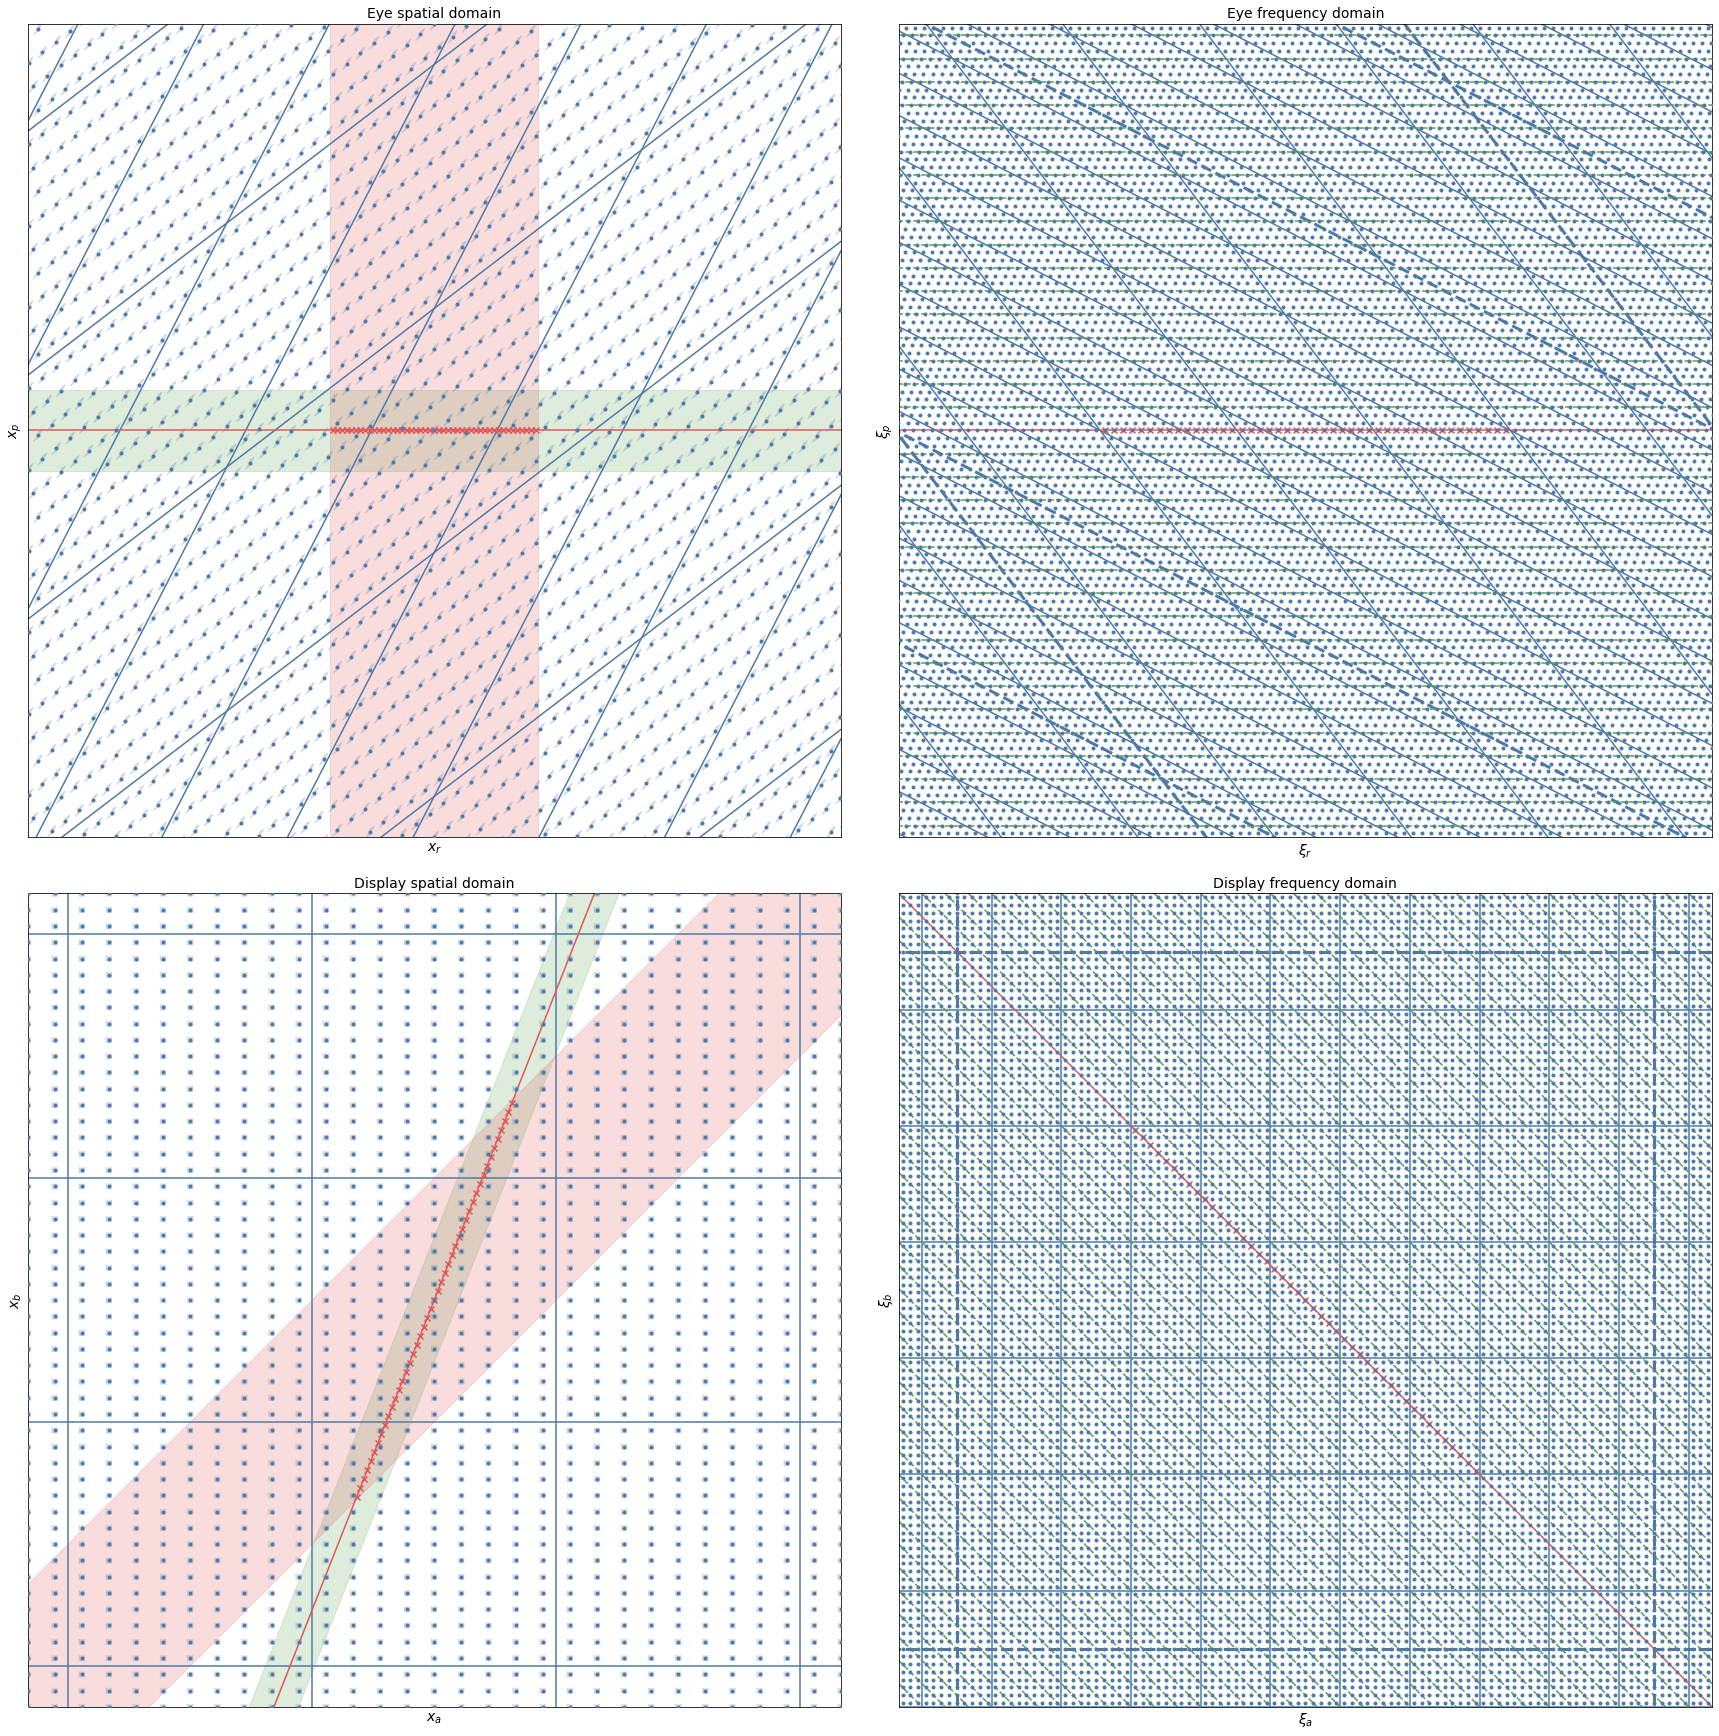

In [7]:
plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f, 50, 7)

From the periodic display resolutions $n_{a}$ and $n_{b}$ we have:
$$ \large \begin{align*}
    n_r &= \mathrm{lcm} (n_{a}, n_{b}) && (11)\\
    n_p &= \mathrm{gcd} (n_{a}, n_{b}) && (12)\\
    n_r \, n_p &= n_a \, n_b && (13)\\
\end{align*} $$

Setting the display signal periods $s_{a}$ and $s_{b}$ as:
$$ \large \begin{align*}
    s_{a} = s_{b} &= n_p \, s_{p} && (14)\\
\end{align*} $$

The period induced in the signal formed on the retina becomes:
$$ \large \begin{align*}
    s_{r} &= \frac{\lvert z_r \rvert}{\lvert z_b - z_a \rvert} n_p \, s_{p} && (15)\\
\end{align*} $$

Therefore the retina sampling period $\Delta x_{r}$ and the display sampling periods $\Delta x_{a}$ and $\Delta x_{b}$ are:
$$ \large \begin{align*}
    \Delta x_{a} &= \frac{n_p \, s_{p}}{n_a} && (16)\\
    \Delta x_{b} &= \frac{n_p \, s_{p}}{n_b} && (17)\\
    \Delta x_{r} &= \frac{\lvert z_r \rvert}{\lvert z_b - z_a \rvert} \frac{n_p \, s_{p}}{n_r} && (18)\\
\end{align*} $$

The necessary box size for the display reconstruction kernel to linearly interpolate the resulting retina samples is given by:
$$ \large \begin{align*}
    w_{a} = w_{b} = w &= \frac{n_p \, s_{p}}{n_{r}} && (19)\\
\end{align*} $$

The necessary display region given the observer field of view is:
$$ \large \begin{align*}
    \tilde{s}_a &= \frac{\lvert z_a \rvert}{\lvert z_r \rvert} s_{r} + s_{p}= \left( \frac{\lvert z_a \rvert}{\lvert z_b - z_a \rvert} n_p + 1 \right) \, s_{p} && (20)\\
    \tilde{s}_b &= \frac{\lvert z_b \rvert}{\lvert z_r \rvert} s_{r} + s_{p}= \left( \frac{\lvert z_b \rvert}{\lvert z_b - z_a \rvert} n_p + 1 \right) \, s_{p} && (21)\\
\end{align*} $$

The resolution actually needed on the display is then:
$$ \large \begin{align*}
    \tilde{n}_a &= n_a + 2 \lceil \frac{1}{2} \left( \frac{\lvert z_a \rvert}{\lvert z_b - z_a \rvert} n_a + \frac{n_a}{n_p} + \frac{n_a}{n_r} - n_a - 1 \right) \rceil && (22)\\
    \tilde{n}_b &= n_b + 2 \lceil \frac{1}{2} \left( \frac{\lvert z_b \rvert}{\lvert z_b - z_a \rvert} n_b + \frac{n_b}{n_p} + \frac{n_b}{n_r} - n_b - 1 \right) \rceil && (23)\\
\end{align*} $$

If $n_a$ is even:
$$ \large \begin{align*}
    \tilde{n}_a &= 2 \lceil \frac{1}{2} \left( \frac{\lvert z_a \rvert}{\lvert z_b - z_a \rvert} n_a + \frac{n_a}{n_p} + \frac{n_a}{n_r} - 1 \right) \rceil && (24)\\
\end{align*} $$

Else, if $n_a$ is odd:
$$ \large \begin{align*}
    \tilde{n}_a &= 2 \lceil \frac{1}{2} \left( \frac{\lvert z_a \rvert}{\lvert z_b - z_a \rvert} n_a + \frac{n_a}{n_p} + \frac{n_a}{n_r} \right) \rceil - 1 && (25)\\
\end{align*} $$

Either way, we have:
$$ \large \begin{align*}
    \tilde{n}_a &< \frac{\lvert z_a \rvert}{\lvert z_b - z_a \rvert} n_a + \frac{n_a}{n_p} + \frac{n_a}{n_r} + 1 && (26)\\
    \tilde{n}_b &< \frac{\lvert z_b \rvert}{\lvert z_b - z_a \rvert} n_b + \frac{n_b}{n_p} + \frac{n_b}{n_r} + 1 && (27)\\
\end{align*} $$

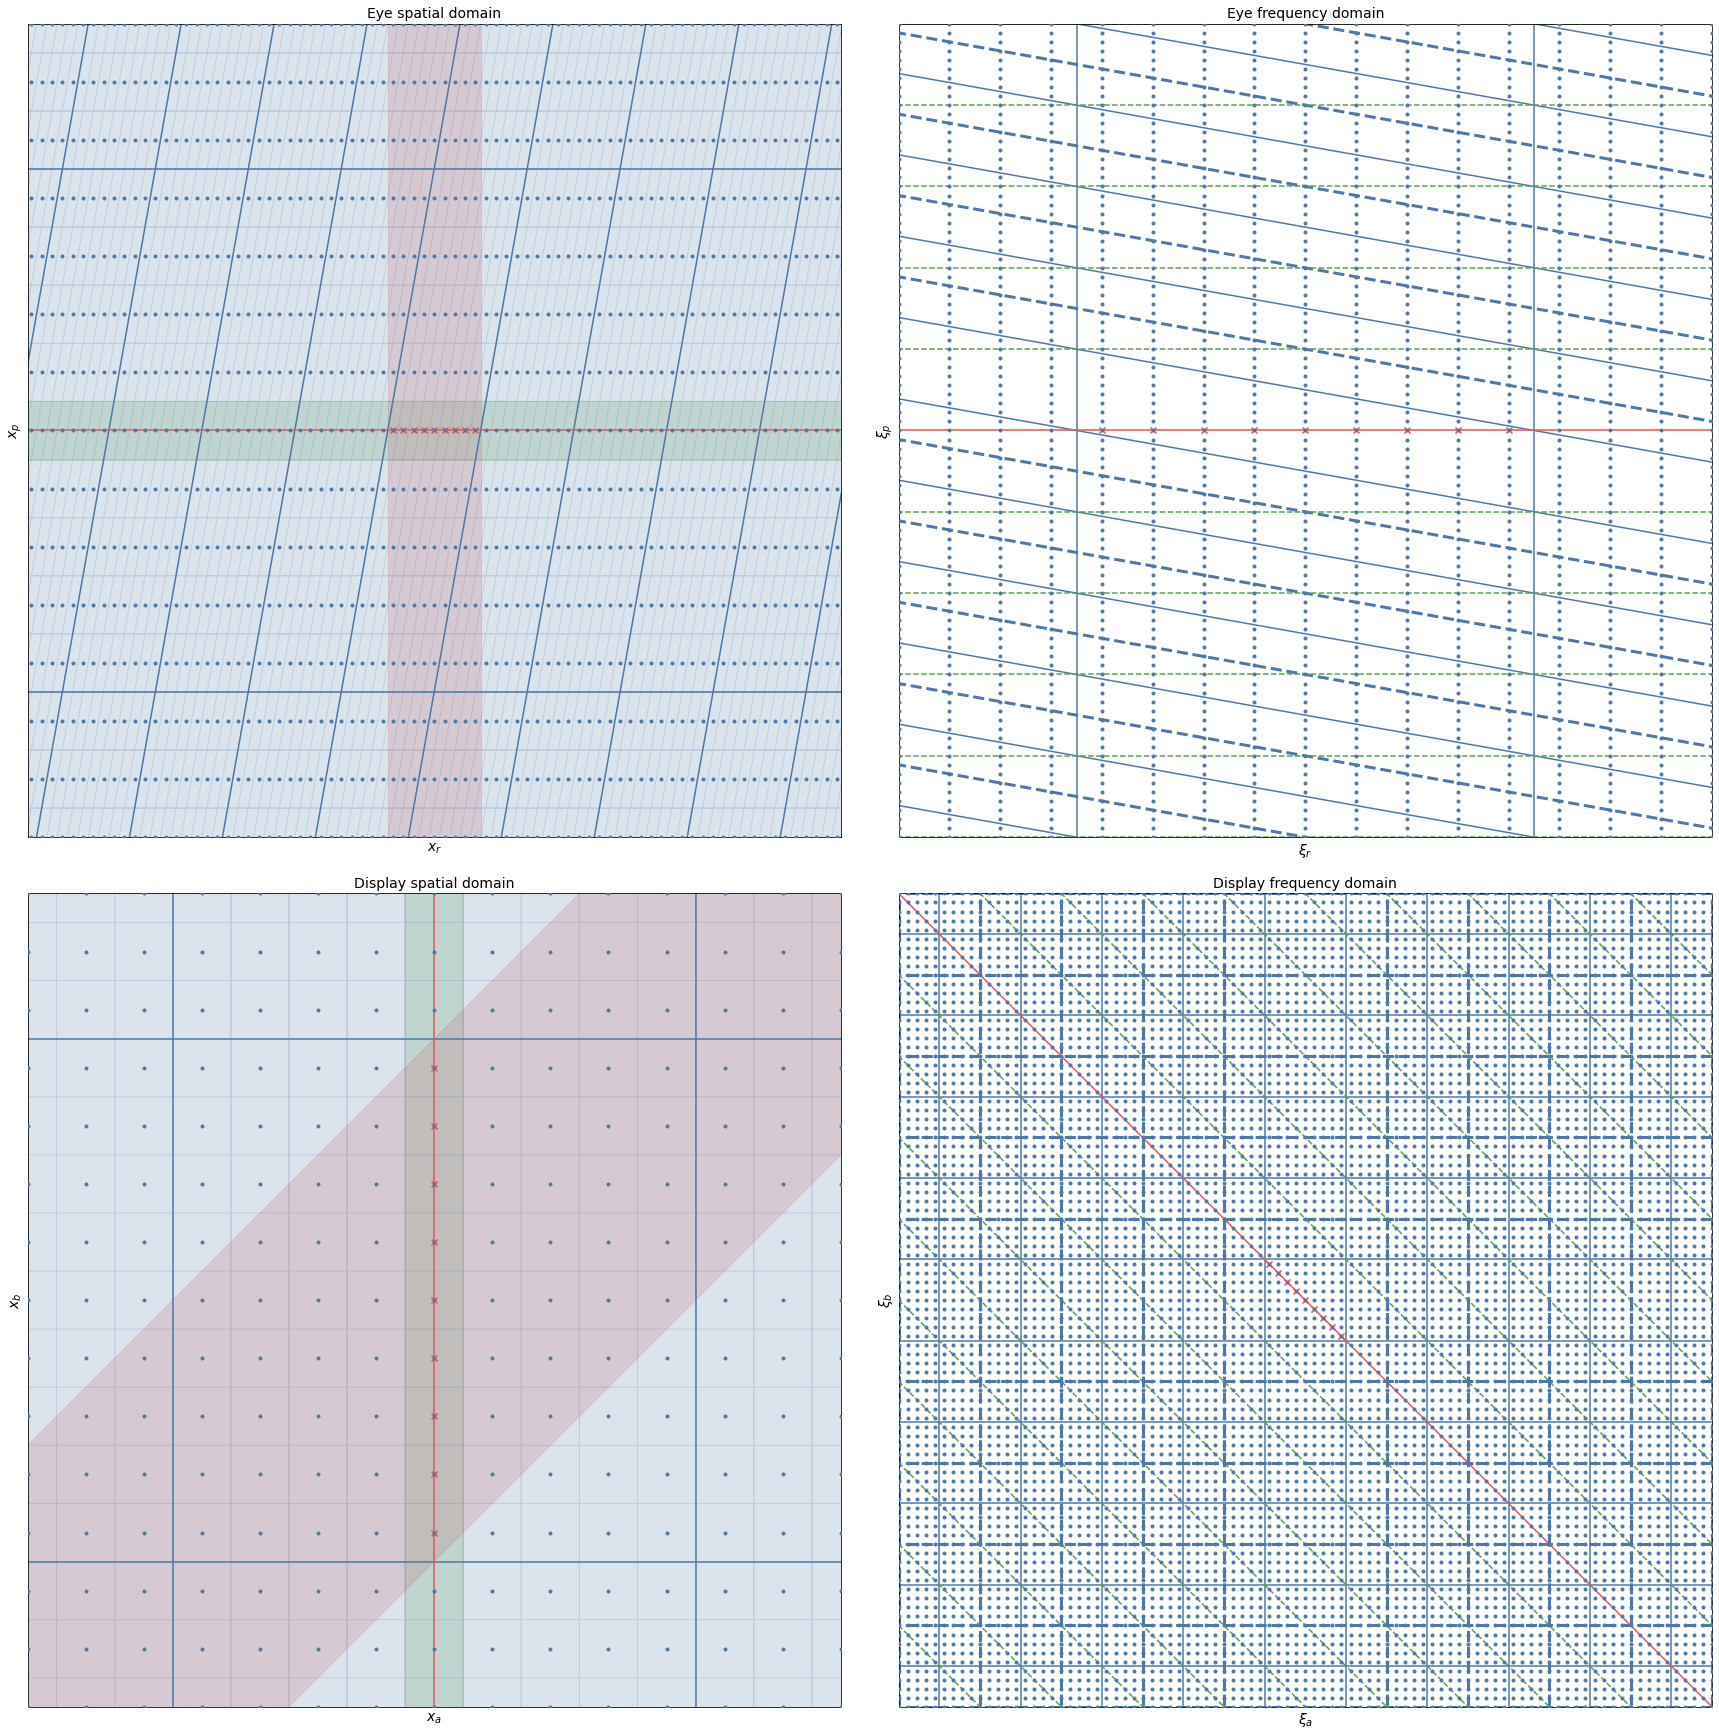

In [8]:
z_r = -17.0
z_f = np.inf

n_r = 9

s_p = 5.0
s_r = 8.0

z_a = 0.0
z_b = np.abs(z_r) * n_r * s_p / s_r

n_a = n_r
n_b = n_r

s_a = s_p * n_r
s_b = s_p * n_r

w_a = s_p
w_b = s_p

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f, 70, 2)

Retina values (min: 0.0, max: 1.0):


Retina spectrum:


Display spectrum:


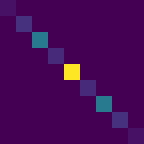

Display values (min: 5.551115123125783e-17, max: 1.0):


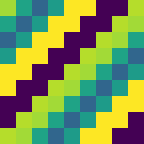

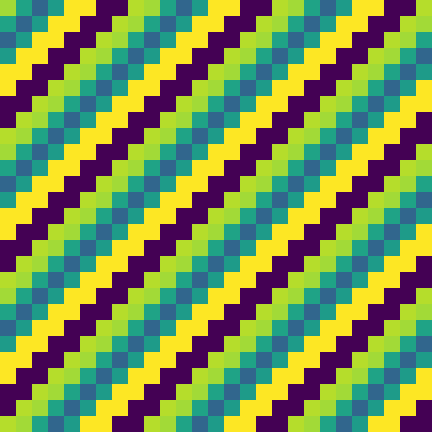

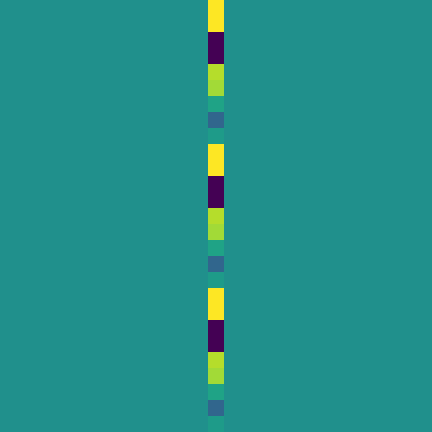

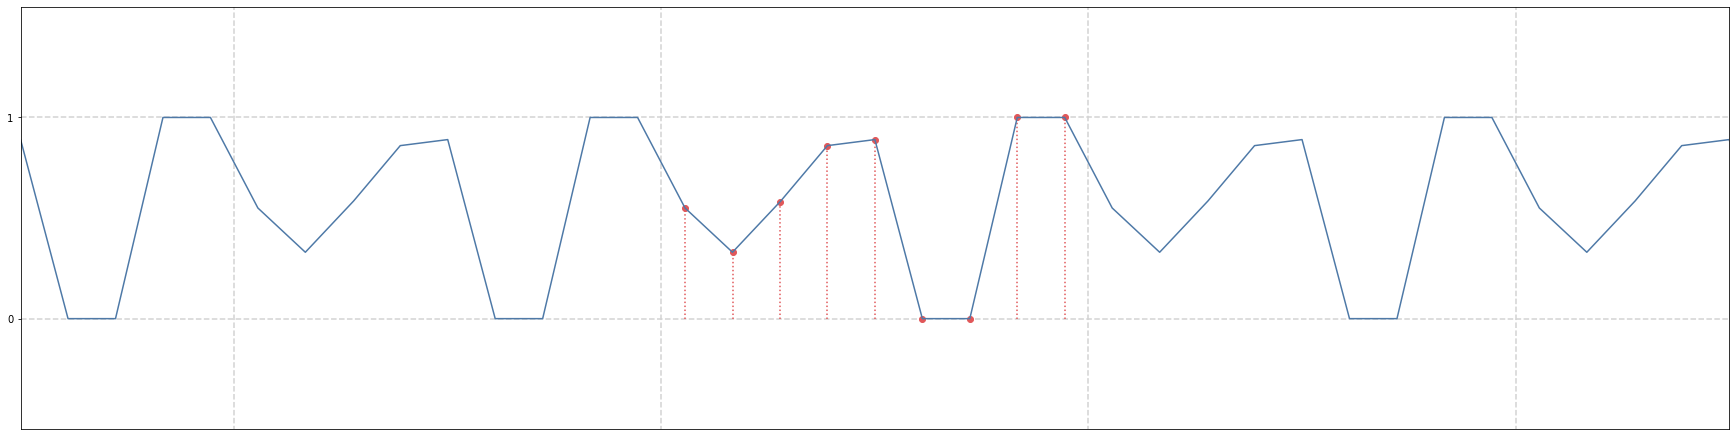

In [9]:
samples_r = np.array([0.55, 0.33, 0.58, 0.86, 0.89, 0.00, 0.00, 1.00, 1.00])

print('Retina values (min: {}, max: {}):'.format(np.amin(samples_r), np.amax(samples_r)))
display_image(np.kron(samples_r, np.ones((16, 16))))

spectrum_r = scipy_fft.fftshift(scipy_fft.fft(scipy_fft.ifftshift(samples_r)))/n_r

print('Retina spectrum:')
display_image(np.kron(np.abs(spectrum_r), np.ones((16, 16))))

spectrum_ab = np.zeros((n_a, n_b), dtype=spectrum_r.dtype)
spectrum_ab[np.flip(np.mod(np.arange(n_r), n_a)), np.mod(np.arange(n_r), n_b)] = spectrum_r

print('Display spectrum:')
display_image(np.kron(np.abs(spectrum_ab), np.ones((16, 16))))

values_ab = np.real(scipy_fft.fftshift(scipy_fft.ifft2(scipy_fft.ifftshift(spectrum_ab * n_a * n_b))))

print('Display values (min: {}, max: {}):'.format(np.amin(values_ab), np.amax(values_ab)))
display_image(np.kron(values_ab, np.ones((16, 16))))

values_ab = np.tile(values_ab, (3, 3))
display_image(np.kron(values_ab, np.ones((16, 16))))
values_ab[:n_r*3//2] = 0.5
values_ab[n_r*3//2+1:] = 0.5
display_image(np.kron(values_ab, np.ones((16, 16))))
values_ab = np.tile(values_ab, (11, 11))

x_r = sampling_coordinates(5 * 999, 5 * s_r)
x_a = sampling_coordinates(33 * n_a, 33 * s_a)
x_b = sampling_coordinates(33 * n_b, 33 * s_b)

img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p, w_a, w_b, z_r, z_a, z_b, z_f)
values_r = np.flip(np.sum(values_ab * img_tsr, axis=(1, 2)))

fig, ax = pyplot.subplots(constrained_layout=True, figsize=(24, 6))

x_plot_size = 4 * s_r

ax.set_xticks([])
ax.set_xlim(-x_plot_size/2, x_plot_size/2)
ax.set_yticks([0.0, 1.0])
ax.set_ylim(-0.55, 1.55)
ax.hlines([0.0, 1.0], -x_plot_size/2, x_plot_size/2, linestyle='dashed', color='lightgrey', zorder=-1)
ax.vlines(np.array([-1.5, -0.5, 0.5, 1.5]) * s_r, -4, 5, linestyle='dashed', color='lightgrey', zorder=-1)
[ln.set_color('lfd:retina') for ln in ax.stem(sampling_coordinates(n_r, s_r), samples_r, linefmt=':', basefmt='none')[0:2]]
ax.plot(x_r, values_r  * np.mean(samples_r) / np.mean(values_r[2*999:3*999]), color='lfd:signal')

pass

From (15) and (19) we have:
$$ \large \begin{align*}
   \frac{\lvert z_b - z_a \rvert}{w} &= \frac{\lvert z_r \rvert}{\Delta x_r} = n_r \frac{\lvert z_r \rvert}{s_r} && (28)\\
\end{align*} $$